## Import Libraries & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('scraping/lamudi_house_price.csv')

### Data Understanding



#### informasi umum dataset

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            1500 non-null   object 
 1   Price            1500 non-null   float64
 2   Bedrooms         1500 non-null   int64  
 3   Living Size(m²)  1500 non-null   float64
 4   Land Size(m²)    1500 non-null   float64
 5   Location         1500 non-null   object 
 6   Timestamp        1500 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 82.2+ KB


- Dataset terdiri dari 1500 rows dan 7 kolom.
- Tidak terdapat missing values pada dataset ini.
- Fitur Title dan Timestamp tidak digunakan dalam modeling sehingga akan di drop pada bagian data preparation.

 **EDA**

#### Data Tidak konsisten atau tidak wajar

In [5]:
data.describe()

,Price,Bedrooms,Living Size(m²),Land Size(m²)
count,1.500000e+03,1500.000000,1500.000000,1.500000e+03
mean,3.203784e+09,3.628667,156.319867,7.797426e+05
std,6.470472e+09,2.918297,156.917200,2.134254e+07
min,1.505000e+08,1.000000,1.000000,2.000000e+00
25%,7.900000e+08,2.000000,60.000000,7.200000e+01
50%,1.600000e+09,3.000000,105.500000,9.900000e+01
75%,3.215596e+09,4.000000,199.000000,1.620000e+02
max,1.350000e+11,40.000000,1860.000000,5.846847e+08


In [6]:
data.sort_values('Land Size(m²)', ascending=False).head()

,Title,Price,Bedrooms,Living Size(m²),Land Size(m²),Location,Timestamp
902,dijual rumah siap huni best view free ppn kota...,5.800000e+08,2,36.0,584684685.0,Semarang,2025-04-27T14:38:22.904871
898,dijual rumah siap huni best view free ppn kota...,5.800000e+08,2,36.0,584684685.0,Semarang,2025-04-27T14:38:10.904757
1430,"di jual 3 unit villa shm luas tanah 4,750m2 pa...",5.500000e+10,11,1400.0,4750.0,Gianyar,2025-04-27T14:43:38.728283
876,stunning ubud leasehold villa surrounded by lu...,1.080000e+10,4,932.0,4439.0,Gianyar,2025-04-27T14:38:04.867344
539,rumah mewah dengan taman luas di taman permata...,1.700000e+10,4,800.0,3050.0,Tangerang,2025-04-27T14:34:50.014004


Ada beberapa nilai tidak wajar pada fitur Living Size(m²)	dan Land Size(m²) di mana nilainya hanya satuan sehingga akan di-setting batas minimum yang wajar untuk ukuran Living Size(m²)	dan Land Size(m²) sebesar 36 m² pada tahap preparation. Juga ada nilai terlampau besar (9 digit) pada Land Size(m²) dan akan dihapus pada bagian data preparation.

#### Distribusi fitur numerik dengan Boxplot

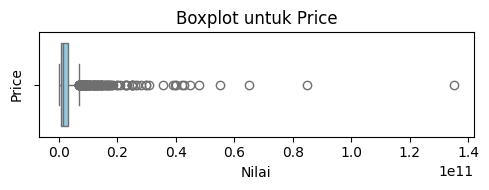

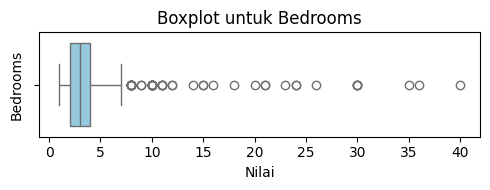

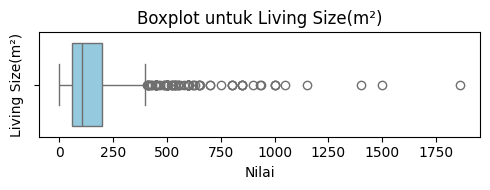

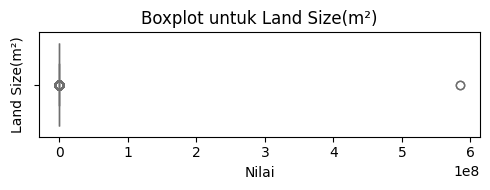

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = data.select_dtypes(include='number').columns

for col in numeric_cols:
    plt.figure(figsize=(5, 2))
    sns.boxplot(data=data[col], orient='h', color='skyblue')

    plt.title(f"Boxplot untuk {col}")
    plt.xlabel("Nilai")
    plt.ylabel(col)

    plt.tight_layout()
    plt.show()


Semua fitur numerik pada dataset ini mengandung outlier sehingga akan dilakukan penghapusan outlier pada bagian data preparation.

#### Distribusi data kategorik

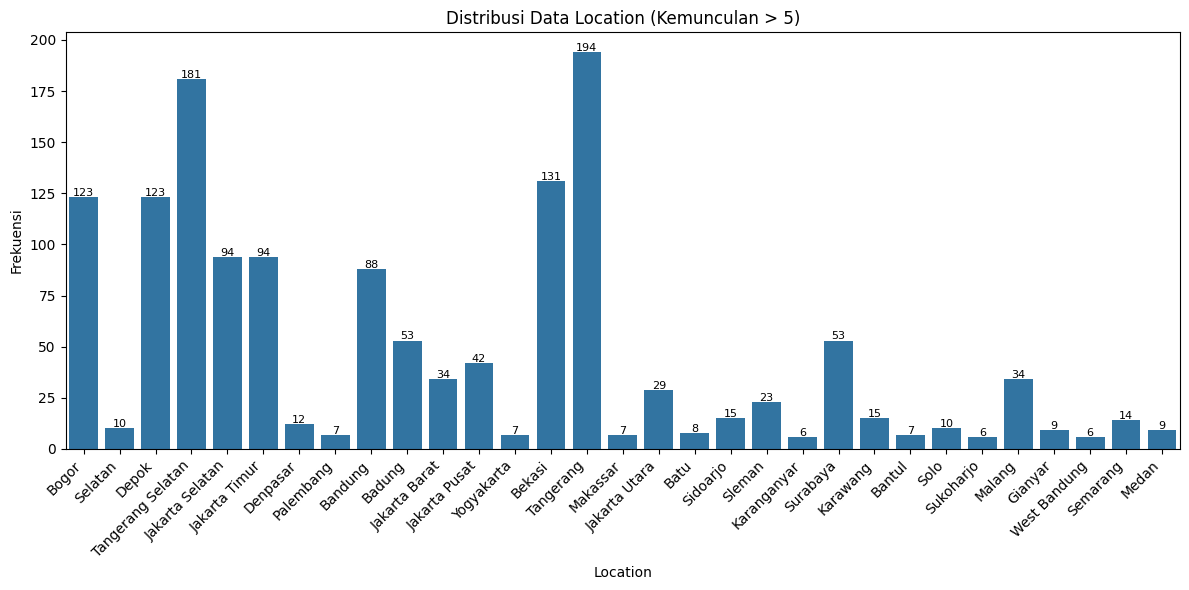

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Salin kolom Location
location_series = data['Location'].copy()

# Filter hanya lokasi dengan kemunculan lebih dari 5
filtered_locations = location_series[location_series.isin(location_series.value_counts()[location_series.value_counts() > 5].index)]

# Plot distribusi lokasi
plt.figure(figsize=(12, 6))
countplot = sns.countplot(x=filtered_locations)
plt.xticks(rotation=45, ha='right')
plt.title("Distribusi Data Location (Kemunculan > 5)")
plt.xlabel("Location")
plt.ylabel("Frekuensi")

# Tambahkan label frekuensi di atas bar
for patch in countplot.patches:
    height = patch.get_height()
    if height > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, height + 0.5,
                 int(height), ha='center', fontsize=8)

plt.tight_layout()
plt.show()


Agar hasil prediksi representatif, salah satu langkah yang ditempuh adalah dengan hanya menggunakan data yang kemunculan kotanya lebih dari 5 kali. Sehingga pada bagian data preparation akan dihapus data dengan kota-kota yang kemunculannya kurang dari 5 kali.

Sama seperti fitur-fitur numerik, distribusi data pada fitur Location tidak seimbang. oleh karena itu proses modeling akan menggunakan kfold cross-validation.

In [9]:
data.duplicated().sum()

np.int64(0)

Tidak ada data duplikat pada dataset ini

### Data Preparation

#### Drop Fitur yang Tidak digunakan

Title dan Timestamp tidak digunakan.

In [10]:
data = data[['Price', 'Bedrooms', 'Living Size(m²)', 'Land Size(m²)',
       'Location']].copy()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price            1500 non-null   float64
 1   Bedrooms         1500 non-null   int64  
 2   Living Size(m²)  1500 non-null   float64
 3   Land Size(m²)    1500 non-null   float64
 4   Location         1500 non-null   object 
dtypes: float64(3), int64(1), object(1)
memory usage: 58.7+ KB


#### Menentukan size minimal Living Size(m²) Land Size(m²)

Hanya akan mempertahankan data dengan minimal Living Size dan Land Size seluas 36 meter persegi.

In [12]:
data[(data['Living Size(m²)'] < 36) | (data['Land Size(m²)'] < 36)]

,Price,Bedrooms,Living Size(m²),Land Size(m²),Location
4,2.500000e+10,7,1.0,782.0,Tangerang Selatan
39,4.771200e+08,2,43.0,22.0,Jakarta Utara
71,6.000000e+08,2,31.0,50.0,Tangerang Selatan
72,5.441780e+08,2,31.0,50.0,Tangerang
86,4.000000e+08,2,30.0,60.0,Bogor
...,...,...,...,...,...
1464,1.850000e+08,2,30.0,60.0,Bekasi
1473,4.500000e+08,2,60.0,33.0,Surabaya
1474,1.850000e+08,2,30.0,60.0,Bekasi
1493,5.039744e+08,3,34.0,72.0,Bogor


In [13]:
drop_value = (data['Living Size(m²)'] < 36) | (data['Land Size(m²)'] < 36)
data = data[~drop_value].copy()

#### Hapus data duplikat

In [15]:
data = data.drop_duplicates()

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1253 entries, 0 to 1499
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price            1253 non-null   float64
 1   Bedrooms         1253 non-null   int64  
 2   Living Size(m²)  1253 non-null   float64
 3   Land Size(m²)    1253 non-null   float64
 4   Location         1253 non-null   object 
dtypes: float64(3), int64(1), object(1)
memory usage: 58.7+ KB


#### Gunakan hanya lokasi dengan total rumah dijual lebih dari 5

In [17]:
location_counts = data['Location'].value_counts()
valid_locations = location_counts[location_counts > 5].index
data = data[data['Location'].isin(valid_locations)]

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1194 entries, 0 to 1499
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price            1194 non-null   float64
 1   Bedrooms         1194 non-null   int64  
 2   Living Size(m²)  1194 non-null   float64
 3   Land Size(m²)    1194 non-null   float64
 4   Location         1194 non-null   object 
dtypes: float64(3), int64(1), object(1)
memory usage: 56.0+ KB


In [19]:
data.groupby('Location').size().reset_index(name='Total_Rows')

,Location,Total_Rows
0,Badung,49
1,Bandung,71
2,Bantul,7
3,Bekasi,108
4,Bogor,106
5,Denpasar,12
6,Depok,110
7,Gianyar,8
8,Jakarta Barat,33
9,Jakarta Pusat,23


#### Handling Outliers

In [20]:
df = data.copy()

Penangan outlier dilakukan menggunakan metode IQR.

In [21]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask = ~((df_numeric < lower_bound) | (df_numeric > upper_bound)).any(axis=1)
df = df.loc[mask].reset_index(drop=True)

In [22]:
df.describe()

,Price,Bedrooms,Living Size(m²),Land Size(m²)
count,1.003000e+03,1003.000000,1003.000000,1003.000000
mean,1.972755e+09,3.118644,120.787438,112.505982
std,1.483393e+09,0.899590,73.410662,57.200539
min,2.000000e+08,2.000000,36.000000,37.000000
25%,8.500000e+08,2.000000,64.000000,72.000000
50%,1.500000e+09,3.000000,100.000000,96.000000
75%,2.692986e+09,4.000000,160.000000,135.000000
max,7.300000e+09,5.000000,400.000000,338.000000


Hasil prediksi dari model ini akan OK jika rumah yang akan diprediksi memiliki bedrooms tidak lebih dari 5, Living Size di antara 36 hingga 400 meter persegi dan Land Size di antara 37 hingga 338 meter persegi.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price            1003 non-null   float64
 1   Bedrooms         1003 non-null   int64  
 2   Living Size(m²)  1003 non-null   float64
 3   Land Size(m²)    1003 non-null   float64
 4   Location         1003 non-null   object 
dtypes: float64(3), int64(1), object(1)
memory usage: 39.3+ KB


#### Logarithmic Transformation

- Untuk semua fitur numerik selain Price, yang distribusi datanya memiliki skewness s di luar rentang -1 < s < 1, pada fitur itu akan dilakukan tranformasi logaritimik.
-  Transformasi logaritmik pada Price akan dilakukan setelah Price didefinisikan sebagai target y agar nilai tranformasinya dapat di inverse sehingga MAE yang terhitung sama dengan selisih harga asli.

In [24]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('Price')  # Exclude target
skew_threshold = 1.0  # Atau threshold lain yang sesuai

for col in numeric_cols:
    skewness = df[col].skew()
    if abs(skewness) > skew_threshold:
        df[col] = np.log1p(df[col])
        print(f'Transformasi log1p pada kolom: {col} (skewness = {skewness:.2f})')

Transformasi log1p pada kolom: Living Size(m²) (skewness = 1.10)
Transformasi log1p pada kolom: Land Size(m²) (skewness = 1.49)


#### Pemisahan Target dan Fitur

Price dipisah menjadi trarget y dan fitur lain menjadi variabel prediktor X.

In [25]:
# Fitur dan target
X = df.drop(columns=['Price'])
y = np.log1p(df['Price'])  # Transformasi logaritmik pada harga

Karena proses modeling menggunakan kfold cross-validation, encoding dan standardisasi dilakukan setelah data splitting disetiap kfold agar data evaluasi tidak bocor ke data pelatihan yang dapat menyebabkan overfitting. data splitting juga dilakukan disetiap kfold (yang mana tahap ini masuk ke bagian Modeling di dalam modul ini).

Namun, untuk memenuhi kriteria struktur penulisan laporan, saya tetap menjelaskan proses data splitting, encoding, dan standardisasi pada bagian data preparation di laporan. Mohon maklumnya reviewer, terima kasih.

In [30]:
!pip install category_encoders

###  Modeling

Ada dua algoritma yang digunakan untuk modeling, yakni Linear Regression dan Support Vector Machine.

Proses modeling ini menggunakan K-Fold Cross Validation karena distribusi data di semua fitur tidak seimbang.

Dalam proses K-Fold Cross Validation, seluruh langkah berikut ini dilakukan di dalam loop KFold:


1. Data Splitting (Train vs Validation):

   - Data `X` dibagi menjadi `X_train` dan `X_val`.
   - Data `y` dibagi menjadi `y_train` dan `y_val`.


2. Encoding dan Standardisasi:

   - encode `X_train['Location']` dan `X_val['Location']`menggunakan `TargetEncoder`.
   - standardisasi `X_train`, `X_val`, `y_train`, `y_val` menggunakan`StandardScaler`.

3. Training Model & Predicts:

   - Model dilatih dengan data training yang sudah di encode dan distandardisasi.
   `model.fit(X_train_scaled, y_train_scaled)`  
   - Kemudian Melakukan prediksi dengan model yang telah dilatih.
   `y_pred_scaled = model.predict(X_val_scaled)`

4. Inverse Standardisasi dan Transformasi:
   - Mengembalikan hasil prediksi ke skala Price asli  dengan fungsi `inverse_transform` dan `expm1`   
   - Pengembalian ke skala Price asli agar hasil MAE di bagian evaluasi mencerminkan selisih harga prediksi dengan harga asli.

5. Evaluasi:

   Evaluasi model menggunakan metrik  MAE dan R²

6. Hasil/nilai dari metrik evaluasi dari setiap iterasi Kfold dikumpulkan ke dalam list.

Kemudian, setelah kfold cross-validation selesai, rata-rata dari score metrik evaluasi untuk setiap model, yang telah disimpan di dalam list dihitung untuk membandingkan model mana yang memiliki rata-rata score lebih baik.

Pada bagian Evaluasi diharapkan MAE menunjukkan selisih harga asli dengan harga prediksi, sehingga dilaporan, proses inverse standardisasi dan inverse transformasi saya sertakan di bagian evaluasi.

#### Linear Regressor

In [31]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder

# Inisialisasi 10-Fold KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
model = LinearRegression()

# Menyimpan metrik
mae_lr_scores = []
r2_lr_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Target encoding
    encoder = TargetEncoder()
    X_train.loc[:, 'Location'] = encoder.fit_transform(X_train['Location'], y_train)['Location']
    X_val.loc[:, 'Location'] = encoder.transform(X_val['Location'])['Location']

    # Standarisasi fitur
    scaler_x = StandardScaler()
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_val_scaled = scaler_x.transform(X_val)

    # Standarisasi target
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).ravel()

    # Latih  model & lakukan prediksi
    model.fit(X_train_scaled, y_train_scaled)
    y_pred_scaled = model.predict(X_val_scaled)

   # Kembalikan prediksi ke skala asli dengan urutan yang benar
    y_pred_log = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()  # Inverse standardisasi
    y_val_log = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1)).ravel()

    # Pastikan nilai berada dalam skala harga asli dengan inverse log transformasi
    y_pred_original = np.expm1(y_pred_log)  # Kembali dari log1p ke harga asli
    y_val_original = np.expm1(y_val_log)

    # Hitung metrik evaluasi dengan harga asli
    mae = mean_absolute_error(y_val_original, y_pred_original)
    r2 = r2_score(y_val_original, y_pred_original)

    mae_lr_scores.append(mae)
    r2_lr_scores.append(r2)

    print(f"Linear Regression - Fold {fold+1} - MAE (harga asli): Rp{mae:,.2f}, R²: {r2:.2f}")


# Rata-rata metrik
print(f"\nLinear Regression - Rata-rata MAE (harga asli): Rp{np.mean(mae_lr_scores):,.2f}, Rata-rata R²: {np.mean(r2_lr_scores):.2f}")


Linear Regression - Fold 1 - MAE (harga asli): Rp632,174,606.37, R²: 0.59
Linear Regression - Fold 2 - MAE (harga asli): Rp681,156,475.07, R²: 0.67
Linear Regression - Fold 3 - MAE (harga asli): Rp545,931,643.16, R²: 0.71
Linear Regression - Fold 4 - MAE (harga asli): Rp724,166,483.17, R²: 0.47
Linear Regression - Fold 5 - MAE (harga asli): Rp591,781,430.59, R²: 0.69
Linear Regression - Fold 6 - MAE (harga asli): Rp508,115,750.90, R²: 0.60
Linear Regression - Fold 7 - MAE (harga asli): Rp461,012,796.09, R²: 0.76
Linear Regression - Fold 8 - MAE (harga asli): Rp570,147,651.97, R²: 0.71
Linear Regression - Fold 9 - MAE (harga asli): Rp661,954,216.76, R²: 0.68
Linear Regression - Fold 10 - MAE (harga asli): Rp606,871,464.53, R²: 0.64

Linear Regression - Rata-rata MAE (harga asli): Rp598,331,251.86, Rata-rata R²: 0.65


#### Support Vector Regressor

In [32]:
from sklearn.svm import SVR

# Inisialisasi 10-Fold KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
model = SVR(kernel='rbf', C=1.0, gamma=0.1)  # Anda bisa mengatur parameter lain jika perlu

# Menyimpan metrik
mae_svr_scores = []
r2_svr_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Target encoding
    encoder = TargetEncoder()
    X_train.loc[:, 'Location'] = encoder.fit_transform(X_train['Location'], y_train)['Location']
    X_val.loc[:, 'Location'] = encoder.transform(X_val['Location'])['Location']

    # Standarisasi fitur
    scaler_x = StandardScaler()
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_val_scaled = scaler_x.transform(X_val)

    # Standarisasi target
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).ravel()

    # Latih dan evaluasi model
    model.fit(X_train_scaled, y_train_scaled)
    y_pred_scaled = model.predict(X_val_scaled)

    # Kembalikan prediksi ke skala asli
    y_pred_log = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_val_log = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1)).ravel()

    # Inverse transformasi log
    y_pred_original = np.expm1(y_pred_log)
    y_val_original = np.expm1(y_val_log)

    # Evaluasi
    mae = mean_absolute_error(y_val_original, y_pred_original)
    r2 = r2_score(y_val_original, y_pred_original)

    mae_svr_scores.append(mae)
    r2_svr_scores.append(r2)

    print(f"SVR - Fold {fold+1} - MAE (harga asli): Rp{mae:,.2f}, R²: {r2:.2f}")

# Rata-rata metrik
print(f"\nSVR - Rata-rata MAE (harga asli): Rp{np.mean(mae_svr_scores):,.2f}, Rata-rata R²: {np.mean(r2_svr_scores):.2f}")

SVR - Fold 1 - MAE (harga asli): Rp572,597,211.94, R²: 0.65
SVR - Fold 2 - MAE (harga asli): Rp690,589,101.08, R²: 0.69
SVR - Fold 3 - MAE (harga asli): Rp555,784,983.98, R²: 0.69
SVR - Fold 4 - MAE (harga asli): Rp670,322,890.04, R²: 0.53
SVR - Fold 5 - MAE (harga asli): Rp560,479,631.57, R²: 0.72
SVR - Fold 6 - MAE (harga asli): Rp527,833,307.50, R²: 0.59
SVR - Fold 7 - MAE (harga asli): Rp471,278,636.09, R²: 0.75
SVR - Fold 8 - MAE (harga asli): Rp569,087,255.84, R²: 0.68
SVR - Fold 9 - MAE (harga asli): Rp664,857,428.01, R²: 0.67
SVR - Fold 10 - MAE (harga asli): Rp553,565,816.64, R²: 0.67

SVR - Rata-rata MAE (harga asli): Rp583,639,626.27, Rata-rata R²: 0.66


In [33]:
# membandingkan rata-rata nilai metrik evaluasi dari kedua model
print(f"\nLinear Regression - Rata-rata MAE (harga asli): Rp{np.mean(mae_lr_scores):,.2f}, Rata-rata R²: {np.mean(r2_lr_scores):.2f}")
print(f"\nSVR - Rata-rata MAE (harga asli): Rp{np.mean(mae_svr_scores):,.2f}, Rata-rata R²: {np.mean(r2_svr_scores):.2f}")


Linear Regression - Rata-rata MAE (harga asli): Rp598,331,251.86, Rata-rata R²: 0.65

SVR - Rata-rata MAE (harga asli): Rp583,639,626.27, Rata-rata R²: 0.66


- model SVR performanya sedikit lebih baik dari model linear regressor, kesalahan prediksi harganya sedikit lebih kecil dan dapat menjelaskan sekitar 66 % variasi harga rumah.
- kedua model belum bisa diproduksi untuk membantu user mengurangi potensi overpaying karena nilai MAE nya masih sangat besar (Rp583,639,626.27) dan R² (66%) tidak cukup besar.
- Selanjutnya, akan ditingkatkan kualitas dan kuantitas dataset, kemudian akan dilakukan hyperparameter tuning pada model SVRd agar memperkecil MAE dan meningkatkat R² sampai nilai yang diharapkan